In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd 
import geoplot as gplt 
import geoplot.crs as gcrs 
import mapclassify as mc
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick

**Read transaction data and map data**

In [10]:
url="https://raw.githubusercontent.com/DrSHendricks/FinTech/main/download_transactions_map.csv"
df=pd.read_csv(url, index_col='id')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ncols=2
df['begin_date']=pd.to_datetime(df['begin_date'])
df['end_date']=pd.to_datetime(df['end_date'])
df['year']=df['begin_date'].dt.year
##worldmaps of occurrence##
world = gpd.read_file(gplt.datasets.get_path('world'))
world = world[world.id !='-99']
world_points=world.copy()
world_points['centroid'] = world_points.centroid
world_points = world_points.set_geometry('centroid')

<ipython-input-10-e6ba074e99bd>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_points['centroid'] = world_points.centroid


**Merge transaction data with map data**

In [11]:
from shapely.geometry import MultiPoint
country_sum=(df.groupby(['originator_iso','beneficiary_iso'])['amount_transactions'].agg(sum)/100000).reset_index()
map_network = world_points.merge(country_sum, left_on="id", right_on="originator_iso")
map_network = world_points.merge(map_network, left_on="id", right_on="beneficiary_iso")

**Map of suspicious transactions flowing in to/out of the US**

"dire" is the direction of stranscations, either 'originator' or 'beneficiary', "top" (int) is the highest ST occurrence.

In [12]:
def mapST(df,dire):
    country_sum=df.groupby([dire+'_iso'])['amount_transactions'].agg(sum)/100000
    map_st = world.merge(country_sum, left_on="id", right_on=dire+'_iso')
    scheme = mc.UserDefined(map_st['amount_transactions'], bins=[2500, 5000, 10000, 50000])
    gplt.choropleth(
        map_st, hue='amount_transactions',
        edgecolor='lightgray', linewidth=1,
        cmap='rainbow', legend=True, legend_kwargs={'loc': 'lower left', 'fontsize':15},
        scheme=scheme, figsize=(15,15),
        legend_labels=['< $2,500 million','$2,500-5,000 million', '$5,000-10,000 million', '$10,000-50,000 million',
             '>$50,000 million'])
    plt.title("Sum of ST by Country between 2000 and 2017",fontsize=20)
    plt.show()

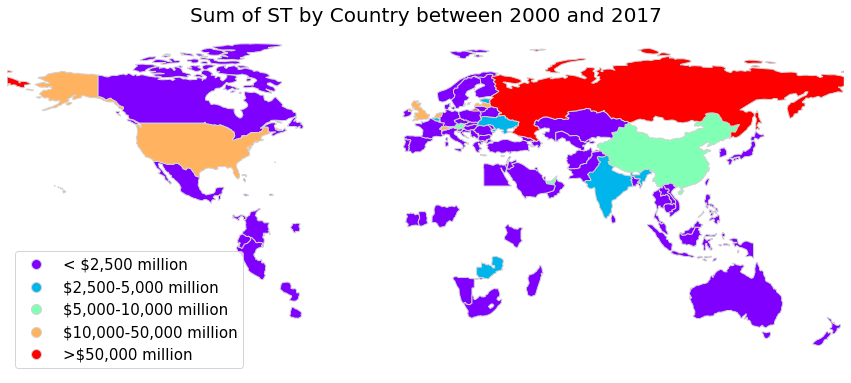

In [13]:
mapST(df,'beneficiary')

**Top N countries of suspicious transactions flowing in/out the US**

In [14]:
def CountrySTFlow(df, dire, country, top):
    df2=df[df[dire+'_iso']==country]
    df2['multi'] = [MultiPoint([x, y]) for x, y in zip(df2.centroid_y, df2.centroid_x)]
    df2=df2.set_geometry('multi')
    df2=df2.nlargest(top, columns=['amount_transactions'])
    scheme = mc.JenksCaspall(df2['amount_transactions'])
    lc=[f'${x:,.0f} million' for x in df2['amount_transactions']] 
    ax = gplt.sankey(df2, projection=gcrs.WebMercator(),
                hue='amount_transactions', scheme=scheme, cmap='Dark2', 
                legend=True,legend_kwargs={'loc': 'lower left', 'fontsize':10},
                legend_labels=lc, figsize=(12,12), linestyles=':')
    gplt.polyplot(world, ax=ax, facecolor='lightgray', edgecolor='white')
    plt.title(f"Sum of top {top} ST of {country} {dire.title()} between 2000 and 2017",fontsize=15)
    plt.show()   


C:\Users\Sherena\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Sherena\anaconda3\lib\site-packages\geoplot\geoplot.py:716: UserWarning: Cound not set plot extent successfully due to numerical instability. Try setting extent manually. Defaulting to a global extent.
  warnings.warn(


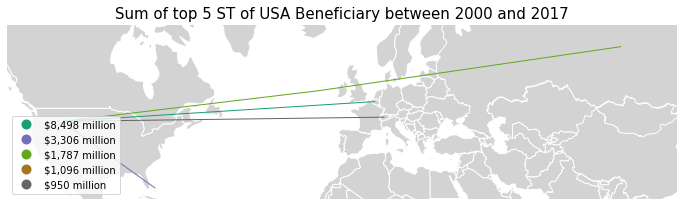

In [15]:
CountrySTFlow(map_network, 'beneficiary', 'USA', 5)

**Number of suspicious transactions per year**

In [16]:
def SumNumberYearlyST (df):
    labels_year, frequencies_year = np.unique(df['year'][~np.isnan(df['year'])], return_counts = True)
    #labels=labels_year.astype(int)
    plt.figure(figsize = (10,10))
    plt.plot(labels_year,frequencies_year)
    plt.title('Number of Suspicious Transactions per Year')
    plt.xticks(np.arange(min(labels_year), max(labels_year)+2, 2))
    plt.yticks(np.arange(min(frequencies_year)-1,max(frequencies_year),50))
    plt.xlabel('Year')
    plt.ylabel('Number of ST')
    plt.show()

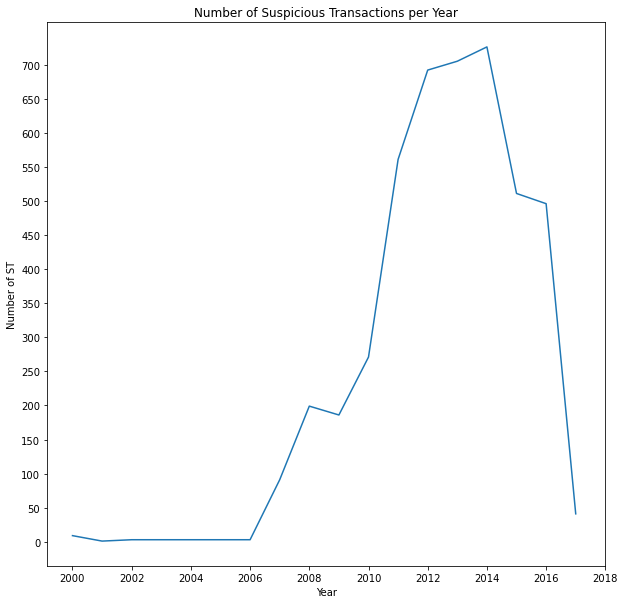

In [17]:
SumNumberYearlyST (df)

**Rank of suspicious transaction numbers by direction.**

In [18]:
def NumberST(df, dire, top): 
    labels_org_con, frequencies_org_con =np.unique(df[dire+'_iso'], return_counts = True)
    count_sort_ind = np.argsort(-frequencies_org_con)
    plt.figure(figsize = (15,15))
    plt.bar(labels_org_con[count_sort_ind][:top],frequencies_org_con[count_sort_ind][:top])
    plt.title(f'Number of Suspicious Transactions in {dire} Country'.title())
    plt.yticks(np.arange(min(frequencies_org_con[count_sort_ind][:top])-20,max(frequencies_org_con),100))
    plt.xlabel(f'Top {top} {dire} Country'.title())
    plt.ylabel('Number of ST')
    plt.show()

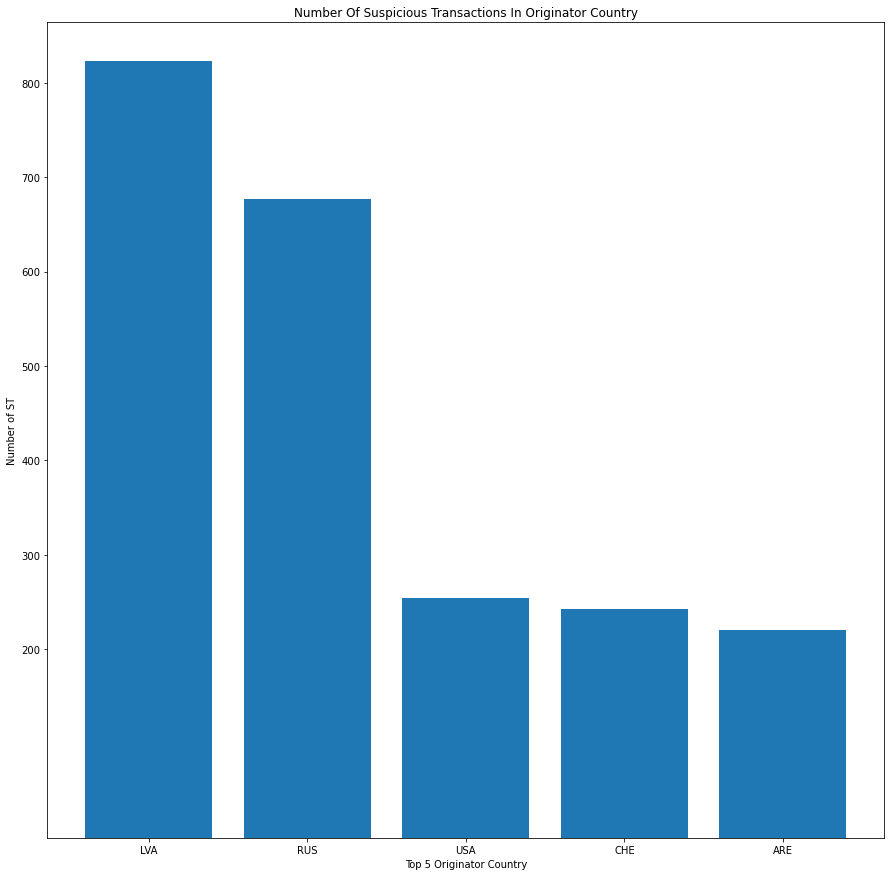

In [19]:
NumberST(df,'originator', 5)  

**Rank of suspicious transaction amounts by direction.**

In [20]:
def HighestST(df, dire, top):
    df1=(df.groupby([dire +'_iso'])['amount_transactions'].sum()/1000000).round(0).nlargest(top).reset_index()
    ax=df1.plot.bar(dire +'_iso', 'amount_transactions', fontsize=15,
                    figsize = (15,15),title=f'Amount of Suspicious Transactions in {dire} Country'.title(),
                    xlabel=f'Top {top} {dire} Country'.title(),ylabel='Amound of ST')
    ax.yaxis.set_major_formatter(tick) 

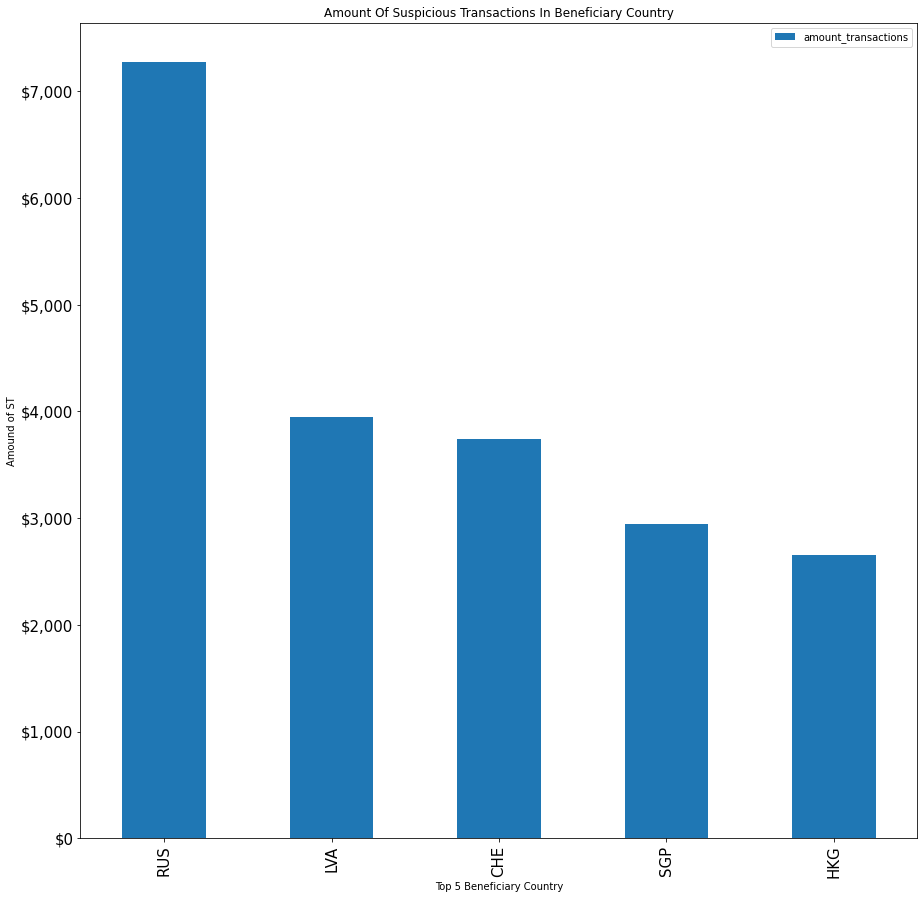

In [21]:
HighestST(df,'beneficiary',5 )

**Top N yearly suspicious transaction countries**

In [22]:
##by transaction amount over year
def STyearly(df,dire, top):
    df1=(df.groupby([dire +'_iso'])['amount_transactions'].sum()/1000000).round(0).nlargest(top).reset_index()
    toplist=list(df1[dire+'_iso'])
    df2=df[['year', dire+'_iso','amount_transactions']].loc[df[dire+'_iso'].isin(toplist)]
    top_year=(df2.groupby([dire+'_iso','year'])['amount_transactions'].sum()/1000000).round(2).reset_index()
    top_year.set_index('year', inplace=True)
    top_year.index.astype(int)
    grouped = top_year.groupby(dire+'_iso')
    nrows = int(np.ceil(grouped.ngroups/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15), sharex=True, sharey=True)
    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        grouped.get_group(key).plot(ax=ax)
        ax.legend([key],loc='upper right', frameon=False)
        ax.yaxis.set_major_formatter(tick) 
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    plt.show() 

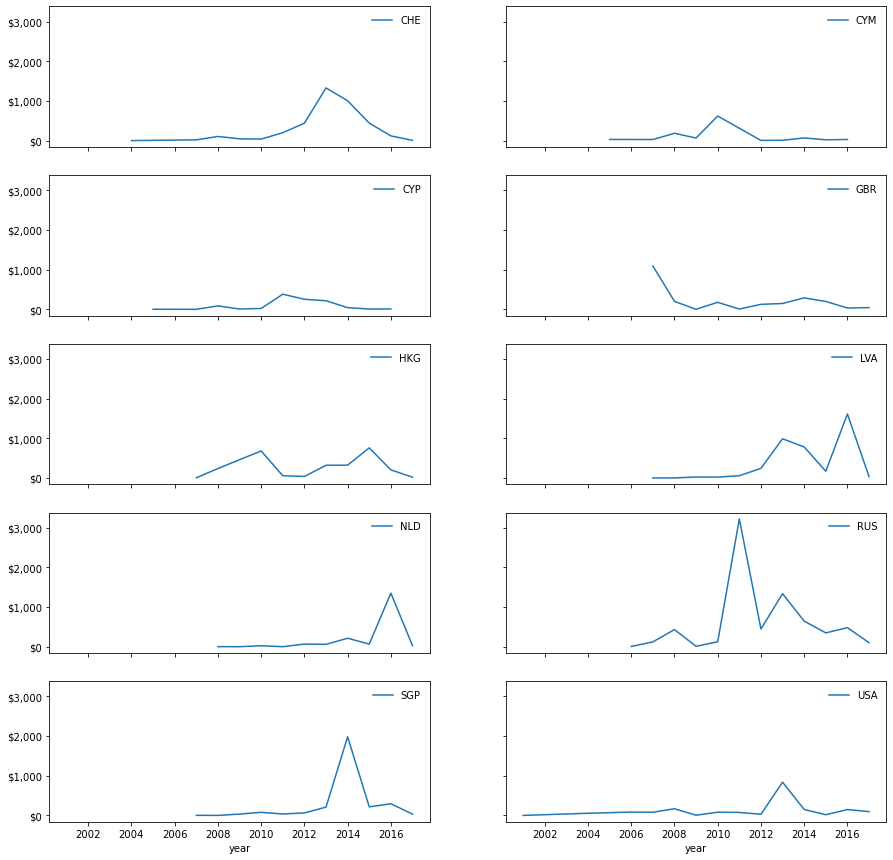

In [23]:
STyearly(df,'beneficiary', 10)